On essaye d'utiliser au maximum uniquement des étiquettes. Ce programme est une refonte de ce qui précède avec des étiquette (et en utilisant mesh=square)

In [1]:
from math import *

def lattice(vertical_vertices, horizontal_vertices):
    'int,int --> list of labels'
    return [i*vertical_vertices+j for i in range(horizontal_vertices) for j in range(vertical_vertices)]
    #O(vertical_vertices*korizontal_vertices)

def edges(vertical_vertices, horizontal_vertices, vertices):
    'int,int,list of labels --> adgency list of labels'
    output = {i: [] for i in vertices}
    for i in vertices:
        row = i // horizontal_vertices
        col = i % horizontal_vertices
        if row > 0:  # not at the top row
            output[i].append((row - 1) * horizontal_vertices + col)
            if col > 0:  # top-left
                output[i].append((row - 1) * horizontal_vertices + col - 1)
            if col < horizontal_vertices - 1:  # top-right
                output[i].append((row - 1) * horizontal_vertices + col + 1)
        if row < vertical_vertices - 1:  # not at the bottom row
            output[i].append((row + 1) * horizontal_vertices + col)
            if col > 0:  # bottom-left
                output[i].append((row + 1) * horizontal_vertices + col - 1)
            if col < horizontal_vertices - 1:  # bottom-right
                output[i].append((row + 1) * horizontal_vertices + col + 1)
        if col > 0:  # not at the left column
            output[i].append(row * horizontal_vertices + col - 1)
        if col < horizontal_vertices - 1:  # not at the right column
            output[i].append(row * horizontal_vertices + col + 1)
    return output
    #O(vertical_vertices*horizontal_vertices)

def obstacles(edges, obstacles):
    'adgency list of labels, list_labels --> adgency list of labels'
    obstacles_set = set(obstacles)
    # Remove obstacle vertices from the edges dictionary
    for obstacle in obstacles_set:
        if obstacle in edges:
            del edges[obstacle]
    # Remove obstacle vertices from adjacency lists
    for vertex in edges:
        edges[vertex] = [neighbor for neighbor in edges[vertex] if neighbor not in obstacles_set]
    return edges
    #O(obstacles*edges)

def label_to_coordinates(vertical_vertices, horizontal_vertices,label):
    '(int),int,label --> coordinates'
    return label%horizontal_vertices,(label-(label%horizontal_vertices))//horizontal_vertices
    #O(1)

def coordinates_to_label(vertical_vertices, horizontal_vertices,vertex):
    '(int),int,coordinates --> label'
    i,j=vertex
    return j*horizontal_vertices+i
    #O(1)

def weight(s1, s2, selector=[1]):
    'coordinates, coordinates, list --> float'
    if selector[0] == 0:
        return abs(s1[0] - s2[0]) + abs(s1[1] - s2[1])  # Manhattan distance
    elif selector[0] == 1:
        return ((s1[0] - s2[0])**2 + (s1[1] - s2[1])**2)**0.5  # Euclidean distance
    elif selector[0] == 2:  # Gradient
        n,h,w= selector[1] #5,10,20

        def func(n, h=None, w=None):
            if n == 1:
                return lambda x, y: atan((y + 1) / (x + 1)) * 2 / pi
            elif n == 2:
                return lambda x, y: 1 / (1 + exp(-(y + 1) / (x + 1)))
            elif w is not None:
                if n == 3:
                    return lambda x, y: atan(w / pi / y) * 2 / pi if y > 0 else 1
                elif n == 4:
                    return lambda x, y: 1 - x / w
            if w is not None and h is not None:
                if n == 5:
                    return lambda x, y: -(y - x) / w + h
            elif n == 6:
                return lambda x, y: sin(x) * 2 / pi
            elif n == 7:
                return lambda x, y: func(6)(y, x)  # sin(y) * 2 / pi
            elif n == 8:
                return lambda x, y: func(6)((x + 1) * (y + 1), 0)  # sin(y*x) * 2 / pi
            elif n == 9:
                return lambda x, y: (cos(x) + cos(y)) / 2
            elif n == 10:
                return lambda x, y: func(9)(x, y + pi)  # (cos(x) - cos(y)) / 2
            elif n == 11:
                return lambda x, y: cos(x) * cos(y)
            elif n == 12:
                return lambda x, y: int(func(11)(x + 1, y + 1) + 1)

        return func(n,h,w)((s1[0] + s2[0]) / 2, (s1[1] + s2[1]) / 2)
    
        #A termes il y aurait un gradient dynamique

def a_star(graph, s0, sf, weight_selector): #graph est une liste d'ajacences en COORDONNÉS
    'dict_coordinates, coordinates, coordinates, list --> list_coordinates'
    W = lambda x,y : weight(x,y,weight_selector)
    open_set = [s0]
    came_from = dict()
    g_score = {vertex: float('inf') for vertex in graph}
    g_score[s0] = 0
    f_score = {vertex: float('inf') for vertex in graph}
    f_score[s0] = W(s0, sf)
    while open_set: #vide pour une liste, un ensemble ou 0 vaut faux
        s = min(open_set, key=lambda x: f_score[x])
        if s == sf:
            path = []
            while s in came_from:
                path.append(s)
                s = came_from[s]
            path.append(s0)
            return path[::-1]
        open_set.remove(s)
        for neighbor in graph[s]:
            tentative_g_score = g_score[s] + W(s, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = s
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + W(neighbor, sf)
                if neighbor not in open_set:
                    open_set.append(neighbor)
    return None  # If there is no path

def path(vertices):
    'list of labels --> list of label couples'
    return [(vertices[i],vertices[i+1]) for i in range(len(vertices)-1)]
    #O(vertices)

def config_gen(vertical_vertices,horizontal_vertices,special_vertices=[]):#renvoie ce qui sera utilisé pour display et A*&Co
    'int,int, list of labels --> adjency list of labels,label,label,list of labels,list of labels'
    import random as rdm
    dimension=vertical_vertices*horizontal_vertices 

    vertices=lattice(vertical_vertices,horizontal_vertices)

    arcs=edges(vertical_vertices,horizontal_vertices,vertices)
    amount=rdm.randint(int(dimension/5),int(dimension/3))
    obstacles_list=[rdm.randint(0,dimension-1) for i in range(amount)]
    obstacles_list=list(set(obstacles_list)) #retire les doublons
    arcs=obstacles(arcs,obstacles_list)

    if not special_vertices:
        amount=rdm.randint(3,10)
        while len(special_vertices)!=amount:
            label=rdm.randint(0,dimension-1)
            if not label in special_vertices and not label in obstacles_list:
                special_vertices.append(label)
    
    tips=[]
    while len(tips)!=2:
        label=rdm.randint(0,dimension-1)
        if not label in tips and not label in obstacles_list:
            tips.append(label)
    s0=tips[0]
    sf=tips[1]

    return arcs,s0,sf,special_vertices,vertices

#Thm: Tout point d'un plus court chemin fourni un plus court chemin depuis une extrémité.
#Soit O une origine, A une arrivé. En notant les chemins entre parenthèses, on considère alors que (OA) est le chemin le plus court.
#Montrons pour tout M dans (OA) que (OM) fourni un plus court chemin
#Par l'absurde, on suppose que (OM) n'est pas le chemin le plus court alors (OM)+(MA) = (OA) n'est plus le chemin le plus court.
#Donc (OM) est nécessairement le plus court.

def multi_a_star(graph,s0,sf,special_vertices,vertices,weight_selector):
    'dict_coordinates, coordinates, coordinates, list of labels, list_coordinates, list --> list_coordinates'
    #Define a path order for special_vertices from A*
    #Move to the closest point and star over
    #Then connect to sf
    A_STAR= lambda x,y : a_star(graph,x,y,weight_selector)
    used=list()
    path=list()
    last_vertex=s0
    while len(used)!=len(special_vertices):
        vertex=min([i for i in special_vertices if i not in used], key=lambda i: len(A_STAR(s0,vertices[i])))
        path+=A_STAR(last_vertex,vertices[vertex])[:-1]
        used.append(vertex)
        last_vertex=vertices[vertex]
    path+=A_STAR(last_vertex,sf)
    return path

def circular_matrix(center,radius):
    'coordinates, int --> list_coordinates /// returns at least the center'
    CourbeSuperieure = lambda x: (radius**2 - x**2)**0.5
    points = []
    for x in range(-radius, radius+1):
        bornesup = CourbeSuperieure(x)
        y = 0
        while y <= bornesup:
            points.append((x+center[0], y+center[1]))
            if y+1<= bornesup:
                points.append((x+center[0], center[1]-(y+1)))
            y += 1
    return points

#Plus court chemin avec les zones d'intérêts change. La liste des points d'intérêt devient une liste de couple (étiquette, rayon)
#multi_a_star change. A terme on créera multi_a_star_v2 en fonction d'une nouvelle heuristique (voir cahier)

def display_graph(vertical_vertices, horizontal_vertices, vertices, special_vertices=[], edges={}, path=[], labels=False):
    'int, int, list_labels, list_labels, dict_labels, list of label pairs, bool --> None'
    import matplotlib.pyplot as plt
    convert = lambda x: label_to_coordinates(vertical_vertices, horizontal_vertices, x)
    # Plot vertices
    coordinates_of_vertices = [convert(i) for i in vertices]
    X = [i[0] for i in coordinates_of_vertices]
    Y = [i[1] for i in coordinates_of_vertices]
    plt.plot(X, Y, 'o', markersize=2, color='blue')
    # Plot edges
    plotted_edges = set()  # To store plotted edges
    for i in edges:
        (a, b) = convert(i)
        for neighbor in edges[i]:
            # Plot edge only if not already plotted
            if (i, neighbor) not in plotted_edges and (neighbor, i) not in plotted_edges:
                (d, c) = convert(neighbor)
                plt.plot([a, d], [b, c], color='grey')
                plotted_edges.add((i, neighbor))  # Add edge to plotted edges
    # Plot path
    for i in range(len(path) - 1):
        label1, label2 = path[i], path[i + 1]
        A = convert(label1)
        B = convert(label2)
        plt.plot([A[0], B[0]], [A[1], B[1]], color='green', linewidth=2)
    # Special points
    if special_vertices:
        special_coordinates = [convert(i) for i in special_vertices]
        X = [i[0] for i in special_coordinates]
        Y = [i[1] for i in special_coordinates]
        plt.plot(X, Y, 'o', markersize=2, color='red')
    # Plot labels if requested
    if labels:
        for i in vertices:
            plt.annotate(str(i), convert(i), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')
    # Plot settings and display
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def super_print(vertical_vertices, horizontal_vertices,vertices):
    'list of labels --> None /// gives directions and vertices where it changes directions' #On utilisera les points cardinaux N,S,E,O,NO,NE,SO,SE
    direction=lambda u,v: (v[0]-u[0],v[1]-u[1])
    convert=lambda x: label_to_coordinates(vertical_vertices,horizontal_vertices,x)
    path=[vertices[0]]
    for i in range(len(vertices)-1):
        dict_directions={(0,1):"N",(0,-1):"S",(-1,0):"O",(1,0):"E",(1,1):"NE",(-1,-1):"SO",(1,-1):"SE",(-1,1):"NO"}
        u=convert(vertices[i])
        v=convert(vertices[i+1])
        if not dict_directions[direction(u,v)]==path[-1]:
            path.append(vertices[i])
        path.append(dict_directions[direction(u,v)])
    path.append(vertices[-1])
    i=0
    while i<len(path)-1:
        if path[i]==path[i+1]:
            path.pop(i+1)
        else:
            i+=1
    for i in range(0,len(path),12):
        print(path[i:i+12])

def export_config(vertical_vertices,horizontal_vertices,s0,sf,edges,special_vertices,weight_selector):
    filename="config.txt"
    with open(filename, "w") as file:
        file.write(f"vertical vertices = {vertical_vertices}\n")
        file.write(f"horizontal vertices = {horizontal_vertices}\n")
        file.write(f"weight_selector : {weight_selector}\n")
        file.write(f"départ : {s0}\n")
        file.write(f"arrivée : {sf}\n")
        file.write(f"points d'intérêt : {special_vertices}\n")
        file.write(f"edges and obstacles / arcs : {edges}")


Exemple de Configuration

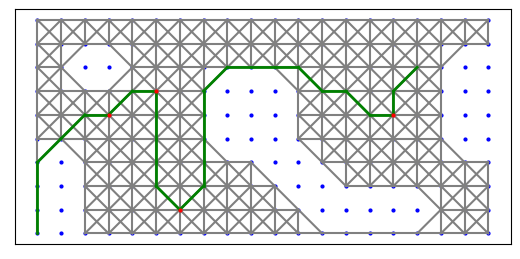

In [2]:
# Configuration
vertical_vertices = 10
horizontal_vertices = 20
selector=[1,()]
s0=0
sf=156
special_vertices=[26,115,125,103]
obstacles_list = [1, 21, 41, 61, 88, 89, 90, 108, 109, 110, 128, 129, 130, 98, 99, 118, 119, 138, 139, 158, 159, 142, 143, 35, 36, 33, 34,70,71,52,51,32]
# Generate lattice vertices
vertices = lattice(vertical_vertices, horizontal_vertices)
# Generate edges and apply obstacles
arcs = edges(vertical_vertices, horizontal_vertices, vertices)
arcs = obstacles(arcs, obstacles_list)
# Convertion
s0 = label_to_coordinates(vertical_vertices, horizontal_vertices, s0)
sf = label_to_coordinates(vertical_vertices, horizontal_vertices, sf)
graph = {label_to_coordinates(vertical_vertices, horizontal_vertices, i): [label_to_coordinates(vertical_vertices, horizontal_vertices, y) for y in arcs[i]] for i in arcs}
# Find solution path
solution = multi_a_star(graph, s0, sf,special_vertices,[label_to_coordinates(vertical_vertices,horizontal_vertices,i) for i in vertices],selector)

sol=([coordinates_to_label(vertical_vertices, horizontal_vertices, i) for i in solution])
#super_print(vertical_vertices,horizontal_vertices,sol)
display_graph(vertical_vertices,horizontal_vertices,vertices,special_vertices,arcs,sol)


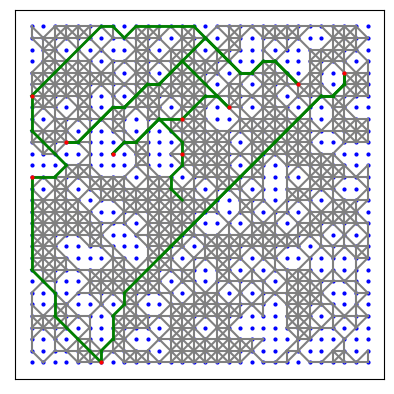

In [3]:
vertical_vertices = 30
horizontal_vertices = 30

selector=[2,(5,vertical_vertices,horizontal_vertices)]

s0=433
sf=281

special_vertices=[643, 690, 677, 480, 6, 573, 547, 777, 743, 553]

vertices = lattice(vertical_vertices, horizontal_vertices)

arcs = 

# Convertion
s0 = label_to_coordinates(vertical_vertices, horizontal_vertices, s0)
sf = label_to_coordinates(vertical_vertices, horizontal_vertices, sf)
graph = {label_to_coordinates(vertical_vertices, horizontal_vertices, i): [label_to_coordinates(vertical_vertices, horizontal_vertices, y) for y in arcs[i]] for i in arcs}
# Find solution path
solution = multi_a_star(graph, s0, sf,special_vertices,[label_to_coordinates(vertical_vertices,horizontal_vertices,i) for i in vertices],selector)

sol=([coordinates_to_label(vertical_vertices, horizontal_vertices, i) for i in solution])
#super_print(vertical_vertices,horizontal_vertices,sol)
display_graph(vertical_vertices,horizontal_vertices,vertices,special_vertices,arcs,sol)

Configuration aléatoire

856 136
[738, 860, 292, 758, 119, 92, 886, 127, 453, 234]


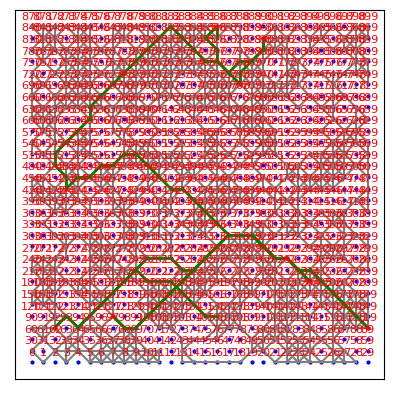

In [8]:
vertical_vertices = 30
horizontal_vertices = 30

selector=[2,(5,vertical_vertices,horizontal_vertices)]

special_vertices=[]

arcs,s0,sf,special_vertices,vertices=config_gen(vertical_vertices,horizontal_vertices,special_vertices)
print(s0,sf)
print(special_vertices)
export_config(vertical_vertices,horizontal_vertices,s0,sf,arcs,special_vertices,(selector[0],selector[1][0]))

#Convertion
s0 = label_to_coordinates(vertical_vertices, horizontal_vertices, s0)
sf = label_to_coordinates(vertical_vertices, horizontal_vertices, sf)
graph = {label_to_coordinates(vertical_vertices, horizontal_vertices, i): [label_to_coordinates(vertical_vertices, horizontal_vertices, y) for y in arcs[i]] for i in arcs}
# Find solution path
solution = multi_a_star(graph, s0, sf,special_vertices,[label_to_coordinates(vertical_vertices,horizontal_vertices,i) for i in vertices],selector)

sol=([coordinates_to_label(vertical_vertices, horizontal_vertices, i) for i in solution])
#super_print(vertical_vertices,horizontal_vertices,sol)
display_graph(vertical_vertices,horizontal_vertices,vertices,special_vertices,arcs,sol,True)

